**Title**


**Introduction**

**Methods and Results**

Loading Packages:

We loaded the relevant packages to our data analysis using the library function. The tidyverse package allows us to use functions to load in and wrangle our data set. The tidymodels packages allows us to use functions that are relevant to creating our classification algorithm such as the recipe and workflow commands.. The supressPackageStartupMessages function used while loading in tidyverse and tidymodels tells R to hide the start-up messages that appear when loading in these packages, this was done for clarity purposes.

In [23]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(GGally))

Reading In The Data Set:

We assigned the link of the data set found online to an object called 'url'. Next, we used the read_csv command to load in the raw data from the web and assigned this dataframe to an object called 'cleveland_heart_data'. Furthermore, while loading in the data we specified that the raw data set from the web did not have any column names and we used the rename command to manually add in the name of the columns which was specified on the website where the dataframe was loaded from.

In [4]:
url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_heart_data<-read_csv(url, col_names=FALSE)%>%
rename(age=X1,
       sex=X2,
       cp=X3,
       trestbps=X4,
       chol=X5,
       fbs=X6,
       restecg=X7,
       thalach=X8,
       exang=X9,
       oldpeak=X10,
       slope=X11,
       ca=X12,
       thal=X13,
       num=X14)     

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Wrangling The Data:

The original data set is difficult to understand as it represented the values of many variables with numbers instead of assigning them names. For example, male and female were represented by 0 and 1. In order to comprehend the dataset better we used the ifelse function to convert most of the variables represented by numbers into characters, allowing us to have a dataframe the is more easily interpretable. 

In [5]:
cleveland_heart_data$sex<-ifelse(cleveland_heart_data$sex == 1, 'male', 'female')

cleveland_heart_data$fbs<-ifelse(cleveland_heart_data$fbs == 1, '>120', '<120')

cleveland_heart_data$exang<-ifelse(cleveland_heart_data$exang == 1, 'yes', 'no')

cleveland_heart_data$num<-ifelse(cleveland_heart_data$num == 0, 'no_disease', 'has_disease')

cleveland_heart_data$cp<-ifelse(cleveland_heart_data$cp == 1, 'typical_angina',
                                ifelse(cleveland_heart_data$cp == 2, 'atypical_angina',
                                       ifelse(cleveland_heart_data$cp == 3, 'non_anginal_pain', 'asymptomatic')))

cleveland_heart_data$slope<-ifelse(cleveland_heart_data$slope == 1, 'upsloping',
                                   ifelse(cleveland_heart_data$slope == 2, 'flat', 'downsloping'))

Next, we converted the num variable into a factor type variable using the mutate function and used the as_factor function as an argument to specify the change in the data type of the column. The 'num' variable will serve as a response variable in our classification problem, therefore we need to ensure that it is recognized by R (and our classification algorithm) as a categorical variable so that the classifier understands there is a set number of values possible to classify an observation wtih, instead of a spectrum or range of values.

In [6]:
cleveland_heart_data<-cleveland_heart_data%>%
mutate(num=as_factor(num))

Since the data set we wrangled has many unnecessary variables for our classification, we decided to reduce the size of the dataframe and select only the variables that are relevant for our classification problem, as the other variables made the dataframe too distracting. We used the select function to do this.

In [7]:
cleveland_heart_data<-cleveland_heart_data%>%
select(chol, trestbps, thalach, num)
head(cleveland_heart_data)

chol,trestbps,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
233,145,150,no_disease
286,160,108,has_disease
229,120,129,has_disease
250,130,187,no_disease
204,130,172,no_disease
236,120,178,no_disease


Before we begin training our classifier, we conduct exploratory data analysis to provide us with more insight about our dataset. First we create a summary table of our response variable, showing a count of how many observations show the presence of heart disease and how many do not show heart disease We first group_by our response variable column and then summarize to generate a count of each category that we groupped by. The table shows that there is a relatively equal number of both categories in our data set, implying that when we are building our model we do not need to balance our response variable.

In [9]:
class_count<-cleveland_heart_data%>%
group_by(num)%>%
summarize(n=n())
class_count

num,n
<fct>,<int>
no_disease,164
has_disease,139


Second, we plot a histogram of all of our intended predictor variables by calling the ggplot and geom_histogram functions. We also utilize the labs, theme and ggtitle functions to improve the visualization of the histograms by adding proper labels and manipulating the size of our plots. These histograms provide us with useful insight about the distribution of each of our predictor variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



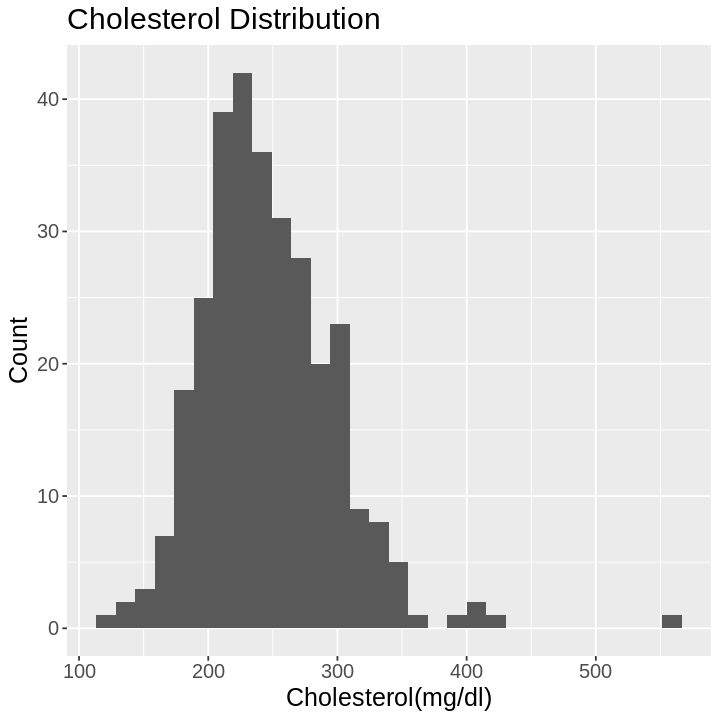

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



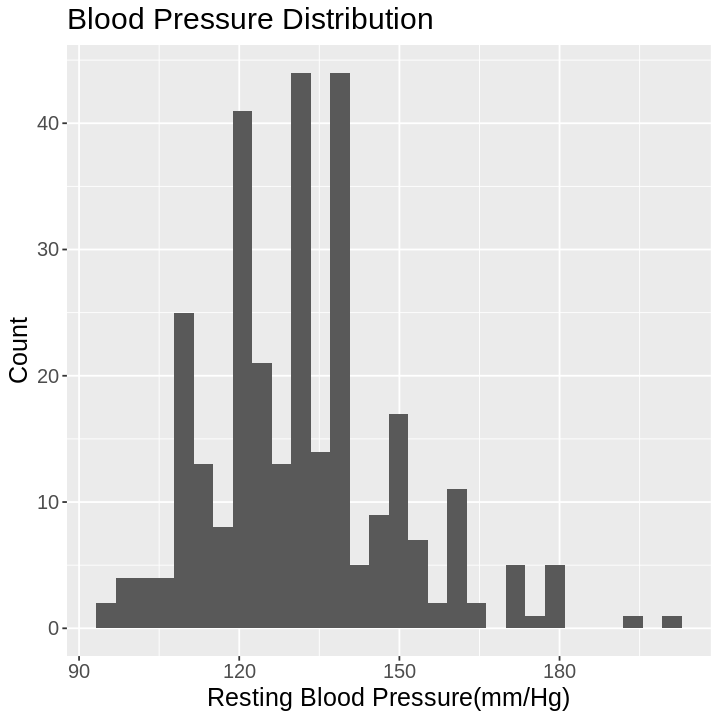

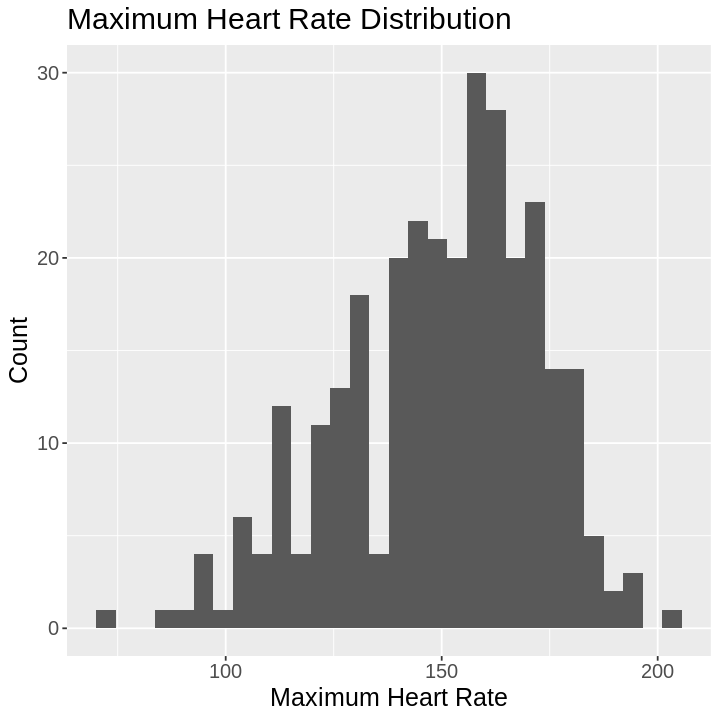

In [26]:
options(repr.plot.width=6,repr.plot.height=6)
chol_plot<-cleveland_heart_data%>%
ggplot(aes(x=chol))+
geom_histogram()+
labs(x="Cholesterol(mg/dl)", y="Count")+
theme(text=element_text(size=15))+
ggtitle("Cholesterol Distribution")

options(repr.plot.width=6,repr.plot.height=6)
trestbps_plot<-cleveland_heart_data%>%
ggplot(aes(x=trestbps))+
geom_histogram()+
labs(x="Resting Blood Pressure(mm/Hg)", y="Count")+
theme(text=element_text(size=15))+
ggtitle("Blood Pressure Distribution")

options(repr.plot.width=6,repr.plot.height=6)
thalach_plot<-cleveland_heart_data%>%
ggplot(aes(x=thalach))+
geom_histogram()+
labs(x="Maximum Heart Rate", y="Count")+
theme(text=element_text(size=15))+
ggtitle("Maximum Heart Rate Distribution")

chol_plot
trestbps_plot
thalach_plot

Before we begin training our classification model, we randomly split our overall dataframe into two subsets of data (training dataset and testing dataset) using the initial_split function. At the end of our analysis this will allow us to provide our model with data that it has not seen before and therefore we can properly assess its accuracy based on the predictions it will make on the unseen data. We assign our training dataset to an object called heart_train, which is what we will use to train the classification model. Further, we assign our testing dataset to an object called heart_test. The testing dataset is what we will use to determine our classifier's accuracy after it has been trained with the training dataset. We have specified that we will devote 75% of the initial data (cleveland_heart_data) to the training dataset and 25% of it to the testing data set by specifying that prop=0.75 in the initial_split function. Furthermore, we also specify that strata=num, our response variable, to ensure that both the training and testing datasets have an equal proportions of 'has_disease' and no_disease' (the possible categories of our response variable). Finally, because we are telling R to randomly split our data, we set our seed value (1772), to ensure that our code is reproducible. 

In [6]:
set.seed(1772)
heart_split<-initial_split(cleveland_heart_data, prop=0.75, strata=num)
heart_train<-training(heart_split)
heart_test<-testing(heart_split)

Next we begin to pre-process our training data set, we accomplish this by creating a recipe by using the recipe function provided by tidymodels. First, we specify that are are using the 'num' column as our response variable, and that cholesterol, resting blood pressure and maximum heart rate are the predictor variables that we are using for this analysis. We further specify that we are creating this recipe from only our training data, as the testing data is not going to be used for any of the model training. Afterwards we state that we want to center and scale all of our predictor variables so that they each have a mean of 0 and a standard deviation of 1. We do this so that all of the predictor variables are on an equal scale and contribute equally to finding the nearest neighbor through the distance formula, if they were not on equal scales, the scale of one predictor may influence the nearest neighbors more than the other predictors. This was accomplished by using step_scale and step_center functions respectively.

After the recipe was created we create our model specification by using the nearest_neighbor command. We set the weight_func argument to rectangular to inform our model to use the straight line distance formula when calculating the distance between points in the dataset. We need to use cross-validation to pick the best K value for our model so we set the neighbors argument to tune(). This allows us to determine the accuracy for a list of k values that we specify in the next steps. To finalize our model specification we indicate that our model will be trained using a k-nearest neighbor computational engine and that it will be addressing classification problems by using the set_engine and set_mode functions.

In [7]:
heart_recipe<-recipe(num ~ chol+trestbps+thalach, data=heart_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

heart_knn<-nearest_neighbor(weight_func="rectangular", neighbors=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

We use the tibble function to create a table that consists of a column named 'neighbors' that has the values from 1 to 100 increasing by increments of 2. These are the values of k whose accuracy we have chosen compute during the cross validation analysis that we will perform. We only choose odd numbers to prevent a tie from occurring.

In [8]:
gridvals<-tibble(neighbors=seq(from=1, to=100, by=2))

Next we apply the vfold_cv function to setup the information that we need to use to execute the cross-validation. We specify that we are going to preform a 5 fold cross validation by setting v=5 and that we will chose one of the evenly sized chunks to iteratively represent the validation set during this analysis. We also indicate that there should be equal numbers of each observation for the response variable in each of the 5 folds of data by setting strata=num.

In [9]:
heart_vfold<-vfold_cv(heart_train, v=5, strata=num)

To execute the cross validation we add the recipe and model we created in previous steps into a workflow. We then call the tune_grid function to fit the model on to the range of possible k values created earlier (gridvals) and execute cross validation using the measures that we defined previously in the object 'heart_vfold'. Afterwards we call collect_metrics to provide us with the statistical results of the cross validation and filter for only the accuracy metric as this is the only measurement relevant to our analysis. We finally arrange our dataframe such that the accuracy (mean column) is arranged in descending order so we can determine the most accurate K value to use.

In [10]:
knn_heart_results<-workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(heart_knn)%>%
    tune_grid(resamples=heart_vfold, grid=gridvals)%>%
    collect_metrics()%>%
    filter(.metric=="accuracy")%>%
    arrange(by=desc(mean))
head(knn_heart_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,accuracy,binary,0.7340184,5,0.04937380,Preprocessor1_Model21
35,accuracy,binary,0.7208740,5,0.05078252,Preprocessor1_Model18
37,accuracy,binary,0.7206763,5,0.05584203,Preprocessor1_Model19
45,accuracy,binary,0.7163329,5,0.05218648,Preprocessor1_Model23
39,accuracy,binary,0.7162319,5,0.05617022,Preprocessor1_Model20
47,accuracy,binary,0.7119851,5,0.05097307,Preprocessor1_Model24


We illustrate the results of our cross-validation by plotting a scatter plot (and line plot that connects the points of the scatter plot to improve clarity) of the accuracy estimate vs the neighbors to help us determine which of the k values is optimal. We use the ggplot command to construct the graph and use geom_point and geom_line respectively to overlay the points and line on to the graph. The graph indicates that k=41 neighbors is optimal for the model we are constructing as it relatively the highest accuracies of all the k values tested and changing this value slightly does not result in very large changes in accuracy.

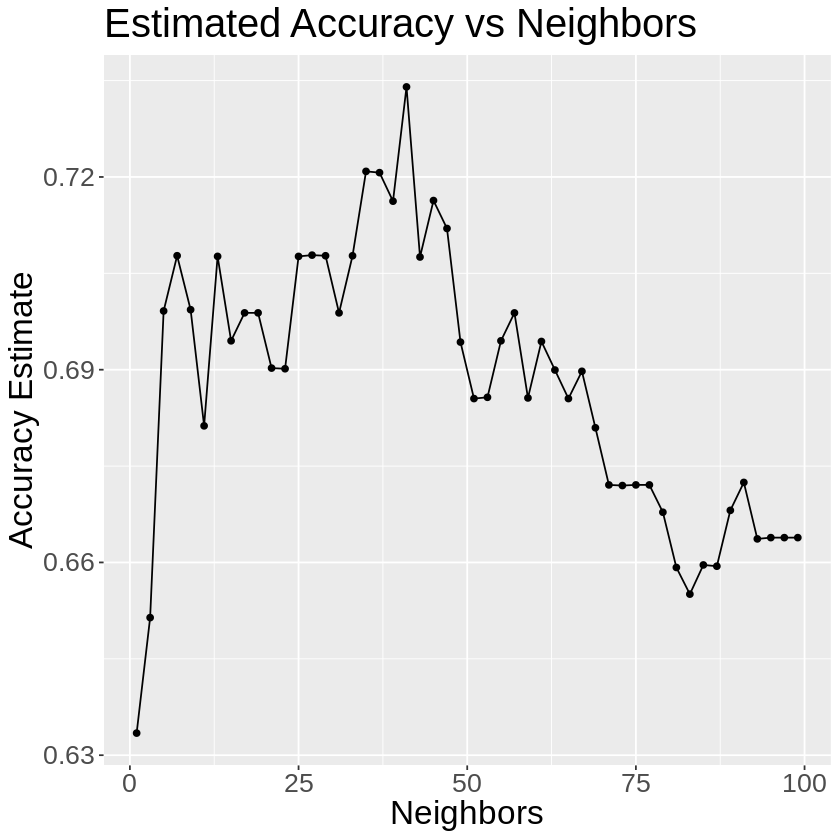

In [11]:
knn_heart_graph<-knn_heart_results%>%
ggplot(aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x="Neighbors", y="Accuracy Estimate")+
theme(text=element_text(size=20))+
ggtitle("Estimated Accuracy vs Neighbors")
knn_heart_graph

We now re-make our model specification with the optimal k value that was extracted from the plot above. We still specify that we want to use the straight line distance to calculate distance between points in our training data and our computational engine and mode remain the same as the previous model specification where the neighbors was set to tune(). Finally, we add our new model specification with k=41 and our recipe (the same recipe created earlier), to a workflow and fit the data on to the training dataset to complete the training of our classification model.

In [12]:
knn_heart_best<-nearest_neighbor(weight_func="rectangular", neighbors=41)%>%
    set_engine("kknn")%>%
    set_mode("classification")

heart_fit<-workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(knn_heart_best)%>%
    fit(data=heart_train)

To assess the accuracy of our model, we use our classifier to predict the labels of the testing data set that was created at the beginning of this anylsis. This is an appropriate method to determine an estimate of how accurate the model is because the classifier has not seen any of the data from the testing set. We use the predict function to tell the classifier to make these predictions on the testing data set and add the resulting column it produces to our test data set. Further we call the metrics function to provide us with the statistical results of the predictions and filter for the accuracy as this is the only measurement relevant to this analysis. Based on this report we can conclude that the accuracy of our classifier is approximately 67%.

In [13]:
heart_predictions<-heart_fit%>%
    predict(heart_test)%>%
    bind_cols(heart_test)%>%
    metrics(truth=num, estimate=.pred_class)%>%
    filter(.metric=="accuracy")
heart_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6710526
